# 필요 라이브러리 import

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split, RandomSampler
import torchvision.models as models
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# 데이터 로드

In [ ]:
transform = transforms.Compose([ # ResNet18모델과 key에 쓰일 약한 Data Transform
    transforms.RandomResizedCrop(size=32, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

query_transform = transforms.Compose([ # query에 쓰일 강한 Data Transform
    transforms.RandomResizedCrop(size=32, scale=(0.2, 1.0)),  # Random Resized Crop
    transforms.RandomHorizontalFlip(p=0.7),  # 50% 확률로 가로로 뒤집음
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomGrayscale(p=0.4),  # 40% 확률로 흑백 변환
    transforms.GaussianBlur(3), # 커널 사이즈 3로 가우시안 블러 적용
    transforms.RandomRotation(degrees=15), # 15도로 회전
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # 정규화
])

In [ ]:
# labeled, unlabeled로 나누는 trainset
dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True)
# test, val로 나누는 valset
valset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

unlabeled_size = int(0.9 * len(dataset))  # 90% 데이터를 unlabel로 (45000개 데이터)
labeled_size = len(dataset) - unlabeled_size  # 10% 데이터를 label로 (5000개 데이터)
unlabeled_dataset, labeled_dataset = random_split(dataset, [unlabeled_size, labeled_size])

class SimCLRDataset(Dataset): # 같은 이미지에 다른 transform을 적용해주어 SimCLR에 맞는 데이터셋을 만들어줌
    def __init__(self, dataset, transform1, transform2):
        self.dataset = dataset
        self.transform1 = transform1
        self.transform2 = transform2

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]

        if isinstance(img, torch.Tensor):  # random_split에서 텐서로 변환되므로 PIL이미지로 바꿔서 transform을 적용해주어야 함
            img = transforms.ToPILImage()(img)

        xi = self.transform1(img)
        xj = self.transform2(img)
        return xi, xj

simclr_dataset = SimCLRDataset(unlabeled_dataset, query_transform, transform)

labeled_dataset.dataset.transform = transform  # transform 적용

test_size = int(0.8 * len(valset))  # 80% 데이터를 testset으로 (8000개 데이터)
val_size = len(valset) - test_size  # 20% 데이터를 validationset으로 (2000개 데이터)
test_dataset, val_dataset = random_split(valset, [test_size, val_size])

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# DataLoader 생성
batch_size = 256

simclr_loader = DataLoader(simclr_dataset, batch_size=256, shuffle=True, num_workers=4)
labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# 학습 파라미터 설정

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
epoch = 50

cuda


# ResNet18로 Baseline Model학습

In [ ]:
# 모델 및 loss func, optimizer불러오기
baseline_model = models.resnet18(weights=None, num_classes=100)  # weights=None : 사전학습 없음
baseline_model = baseline_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=8e-4, weight_decay=6e-4)

In [ ]:
# train, validation진행 함수
def train_baseline(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, device="cuda"):
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []

    for epoch in range(num_epochs): # each epoch
        #train
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train * 100

        # validation
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = running_val_loss / len(val_loader)
        val_acc = correct_val / total_val * 100

        # save log
        train_loss_list.append(avg_train_loss)
        val_loss_list.append(avg_val_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

        # print log
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}% | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}%")

    return train_loss_list, val_loss_list, train_acc_list, val_acc_list

In [ ]:
# test 함수
def test_baseline(model, test_loader, criterion, device="cuda"):
    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    avg_test_loss = running_test_loss / len(test_loader)
    test_acc = correct_test / total_test * 100

    print(f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.4f}%")

    return avg_test_loss, test_acc

In [ ]:
# baseline model학습 진행
bl_trainloss, bl_valloss, bl_trainacc, bl_valacc = train_baseline(baseline_model, labeled_loader,
                                                                  val_loader, criterion, optimizer,
                                                                  num_epochs=epoch, device=device)

Epoch [1/50] | Train Loss: 4.3970, Train Acc: 5.5400% | Val Loss: 4.5688, Val Acc: 2.7500%
Epoch [2/50] | Train Loss: 3.8745, Train Acc: 11.5400% | Val Loss: 4.1582, Val Acc: 6.9500%
Epoch [3/50] | Train Loss: 3.5515, Train Acc: 15.1000% | Val Loss: 3.8597, Val Acc: 12.5500%
Epoch [4/50] | Train Loss: 3.3427, Train Acc: 19.0200% | Val Loss: 3.7632, Val Acc: 13.4000%
Epoch [5/50] | Train Loss: 3.1604, Train Acc: 21.4000% | Val Loss: 3.6963, Val Acc: 14.0000%
Epoch [6/50] | Train Loss: 2.9341, Train Acc: 26.0000% | Val Loss: 3.6474, Val Acc: 14.8500%
Epoch [7/50] | Train Loss: 2.7935, Train Acc: 29.2600% | Val Loss: 3.6937, Val Acc: 16.2000%
Epoch [8/50] | Train Loss: 2.6221, Train Acc: 32.5000% | Val Loss: 3.6064, Val Acc: 17.0500%
Epoch [9/50] | Train Loss: 2.4834, Train Acc: 35.3400% | Val Loss: 3.6718, Val Acc: 16.9000%
Epoch [10/50] | Train Loss: 2.3595, Train Acc: 38.2200% | Val Loss: 3.7422, Val Acc: 17.4000%
Epoch [11/50] | Train Loss: 2.2030, Train Acc: 42.1400% | Val Loss: 3.69

In [ ]:
# baseline model test결과 추출
bl_testloss, vl_testacc = test_baseline(baseline_model, test_loader, criterion, device=device)

Test Loss: 4.2711, Test Acc: 21.8875%


# Self-SL(SimCLR)을 이용해 Our Model 학습

In [ ]:
# SimCLR 모델 구현
class SimCLR(nn.Module):
    def __init__(self, encoder, projection_dim=128):
        super(SimCLR, self).__init__()
        self.encoder = encoder(num_classes=projection_dim)
        self.projection_head = nn.Sequential(
            nn.Linear(projection_dim, projection_dim),
            nn.ReLU(),
            nn.Linear(projection_dim, projection_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.projection_head(h)
        z = F.normalize(z, dim=1)
        return z

In [ ]:
# NT-Xent Loss 정의
def nt_xent_loss(z_i, z_j, temperature=0.5):
    N = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)

    sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)
    sim_exp = torch.exp(sim / temperature)

    mask = (~torch.eye(2*N, 2*N, dtype=bool)).to(z.device)
    sim_exp = sim_exp.masked_select(mask).view(2*N, -1)

    positive_sim = torch.exp(F.cosine_similarity(z_i, z_j, dim=1) / temperature)
    positive_sim = torch.cat([positive_sim, positive_sim], dim=0)

    loss = -torch.log(positive_sim / sim_exp.sum(dim=1)).mean()
    return loss

In [ ]:
# 모델 및 최적화함수 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
simclr_model = SimCLR(models.resnet18).to(device)
optimizer = optim.Adam(simclr_model.parameters(), lr=4e-4)

In [ ]:
# SimCLR 학습
def train_simclr(loader, epochs=10):
    simclr_model.train()

    for epoch in range(epochs):
        total_loss = 0
        for xi, xj in loader:
            xi, xj = xi.to(device), xj.to(device)

            optimizer.zero_grad()
            zi = simclr_model(xi)
            zj = simclr_model(xj)

            loss = nt_xent_loss(zi, zj)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")

In [ ]:
train_simclr(simclr_loader, epochs=50)

Epoch [1/50] Loss: 5.4819
Epoch [2/50] Loss: 5.2369
Epoch [3/50] Loss: 5.1728
Epoch [4/50] Loss: 5.1306
Epoch [5/50] Loss: 5.1080
Epoch [6/50] Loss: 5.0844
Epoch [7/50] Loss: 5.0740
Epoch [8/50] Loss: 5.0609
Epoch [9/50] Loss: 5.0474
Epoch [10/50] Loss: 5.0388
Epoch [11/50] Loss: 5.0213
Epoch [12/50] Loss: 5.0131
Epoch [13/50] Loss: 5.0091
Epoch [14/50] Loss: 5.0012
Epoch [15/50] Loss: 4.9951
Epoch [16/50] Loss: 4.9911
Epoch [17/50] Loss: 4.9818
Epoch [18/50] Loss: 4.9725
Epoch [19/50] Loss: 4.9742
Epoch [20/50] Loss: 4.9639
Epoch [21/50] Loss: 4.9621
Epoch [22/50] Loss: 4.9581
Epoch [23/50] Loss: 4.9523
Epoch [24/50] Loss: 4.9456
Epoch [25/50] Loss: 4.9414
Epoch [26/50] Loss: 4.9378
Epoch [27/50] Loss: 4.9369
Epoch [28/50] Loss: 4.9287
Epoch [29/50] Loss: 4.9278
Epoch [30/50] Loss: 4.9224
Epoch [31/50] Loss: 4.9212
Epoch [32/50] Loss: 4.9158
Epoch [33/50] Loss: 4.9134
Epoch [34/50] Loss: 4.9105
Epoch [35/50] Loss: 4.9077
Epoch [36/50] Loss: 4.9034
Epoch [37/50] Loss: 4.9024
Epoch [38/

In [ ]:
# 분류를 위한 모델 정의 (SimCLR로 사전학습한 encoder 사용)
class Classifier(nn.Module):
    def __init__(self, encoder, num_classes=100):
        super(Classifier, self).__init__()
        self.encoder = encoder.encoder
        self.fc_layers = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        features = self.encoder(x)
        output = self.fc_layers(features)
        return output

In [ ]:
# 모델 및 최적화함수수 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
classifier_model = Classifier(simclr_model).to(device)
optimizer = optim.Adam(classifier_model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_classifier(loader, val_loader, epochs=20):
    classifier_model.train()

    train_loss, train_acc, val_loss, val_acc = [], [], [], []

    # train
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = classifier_model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        avg_loss = total_loss / len(loader)
        accuracy = 100. * correct / total

        # validation
        classifier_model.eval()
        val_total_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = classifier_model(images)
                loss = criterion(outputs, labels)
                val_total_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        avg_val_loss = val_total_loss / len(val_loader)
        val_accuracy = 100. * val_correct / val_total

        # print log
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.2f}%, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        classifier_model.train()

        # save log
        train_loss.append(avg_loss)
        train_acc.append(accuracy)
        val_loss.append(avg_val_loss)
        val_acc.append(val_accuracy)

    return train_loss, train_acc, val_loss, val_acc

In [ ]:
train_loss, train_acc, val_loss, val_acc = train_classifier(labeled_loader, val_loader, epochs=50)

Epoch [1/50] Train Loss: 4.8766, Train Accuracy: 2.50%, Validation Loss: 4.4202, Validation Accuracy: 4.55%
Epoch [2/50] Train Loss: 4.2303, Train Accuracy: 7.38%, Validation Loss: 4.1249, Validation Accuracy: 9.15%
Epoch [3/50] Train Loss: 3.9583, Train Accuracy: 10.62%, Validation Loss: 3.8657, Validation Accuracy: 11.45%
Epoch [4/50] Train Loss: 3.7328, Train Accuracy: 13.02%, Validation Loss: 3.7314, Validation Accuracy: 13.80%
Epoch [5/50] Train Loss: 3.6030, Train Accuracy: 14.14%, Validation Loss: 3.6318, Validation Accuracy: 15.20%
Epoch [6/50] Train Loss: 3.4404, Train Accuracy: 17.54%, Validation Loss: 3.5920, Validation Accuracy: 15.35%
Epoch [7/50] Train Loss: 3.3004, Train Accuracy: 19.10%, Validation Loss: 3.5040, Validation Accuracy: 16.55%
Epoch [8/50] Train Loss: 3.2053, Train Accuracy: 20.46%, Validation Loss: 3.4951, Validation Accuracy: 17.30%
Epoch [9/50] Train Loss: 3.0961, Train Accuracy: 23.06%, Validation Loss: 3.4287, Validation Accuracy: 19.40%
Epoch [10/50] 

In [ ]:
def test_classifier(model, test_loader, criterion, device='cuda'):
    model.eval()
    running_test_loss, correct_test, total_test = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    avg_test_loss = running_test_loss / len(test_loader)
    test_acc = correct_test / total_test * 100

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

    return avg_test_loss, test_acc

In [ ]:
test_loss, test_acc = test_classifier(classifier_model, test_loader, criterion, device)

Test Loss: 4.0482, Test Accuracy: 25.34%


# 학습 경향성 시각화

In [ ]:
def plot_result(bl_val_acc, val_acc, bl_test_acc, test_acc):

    epochs = range(1, len(bl_val_acc) + 1)

    plt.figure(figsize=(8, 6))

    plt.plot(epochs, bl_val_acc, label='Baseline Validation Accuracy')
    plt.plot(epochs, val_acc, label='Fine-tuned Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy Comparison')
    plt.legend()
    plt.text(0.5, max(max(bl_val_acc), max(val_acc)),
             f'Baseline Test Acc: {bl_test_acc:.2f}%\nFine-tuned Test Acc: {test_acc:.2f}%',
             fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()

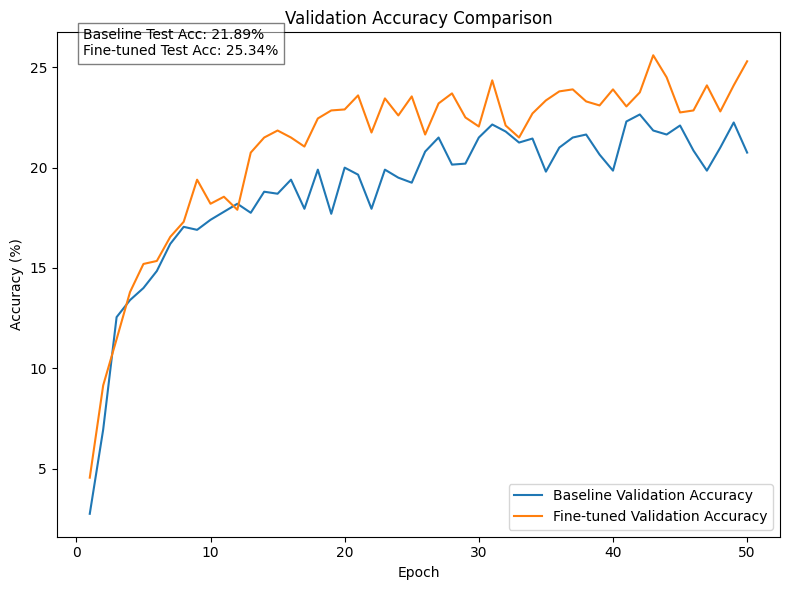

In [ ]:
plot_result(bl_valacc, val_acc, vl_testacc, test_acc)

# 보고서

## 1. CIFAR100 데이터셋

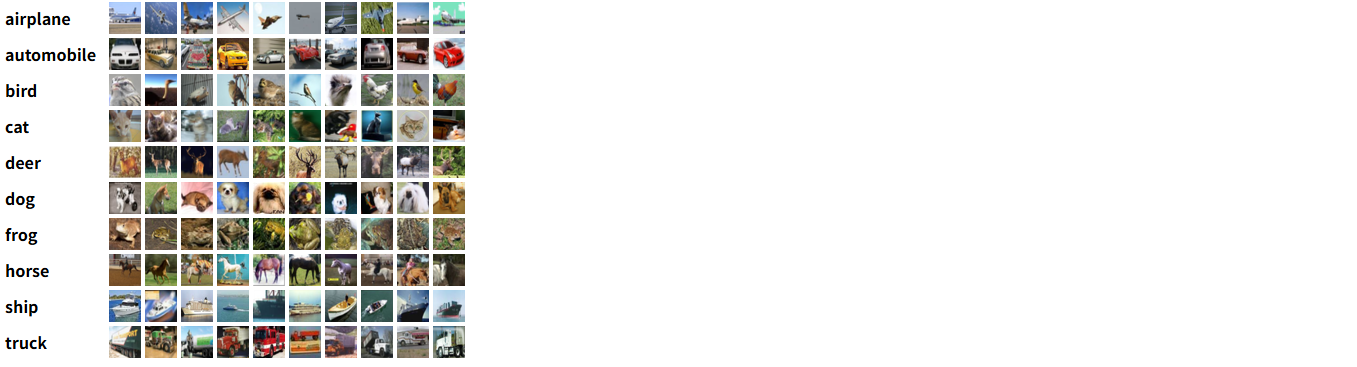

- 다중 클래스 이미지 분류를 위한 벤치마크 데이터셋
- 60,000개의 32×32 크기의 컬러 이미지로 구성되어 있으며, 100개의 클래스가 존재한다.
- 각 클래스는 600개의 이미지(train 500장, test 100장)로 이루어져 있다.
- 데이터 분할
    - train : 50000장(클래스 당 500장)
    - test : 10000장(클래스 당 100장)
- 활용 분야
    - Image Classification: 다양한 객체 분류 모델의 성능을 평가하는 데 사용됨
	- Deep Learning Research: CNN, ResNet 등 딥러닝 기반 이미지 인식 연구에 활용됨
	- Few-shot Learning & Transfer Learning: 데이터가 제한된 환경에서의 학습 및 사전 훈련된 모델의 전이 학습 연구에 사용됨
- 우리는 trainset을 unlabeled : labeled = 90 : 10으로 나누어 self-supervised learning을 진행했다.

## 2. 실험 과정

- train, test 데이터를 다음과 같이 나누어 실험 진행
    - train 10% : labeled data(baseline model, our model의 classifier에 사용)
    - train 90% : unlabeled data(self-supervised learning에 사용, key, query encoder에 넣을 각각의 데이터셋으로 복사해 저장)
    - test 20% : validation data
    - test 80% : test data
- 데이터 증강
    - 강한 변형(query_transform), 약한 변형(transform)으로 나누어 데이터 별 다른 데이터 증강 사용
    - unlabeled data의 query_dataset에는 contrastive learning에서 더 일반화된 특징을 학습하기 위해 강한 변형(query_transform) 사용
    - 나머지 데이터에는 약한 변형(transform) 사용
- 다음 모델 2개를 나누어 loss, 정확도 등 결과를 비교해보고자 함
    1. ResNet18을 사용하며, 오직 10%의 labeled data만으로 supervised learning 진행
    2. SimCLR 기반 self-supervised learning을 unlabeled data로 진행하여 학습된 feature를 기반으로 classification task를 수행

## 3. 실험 결과

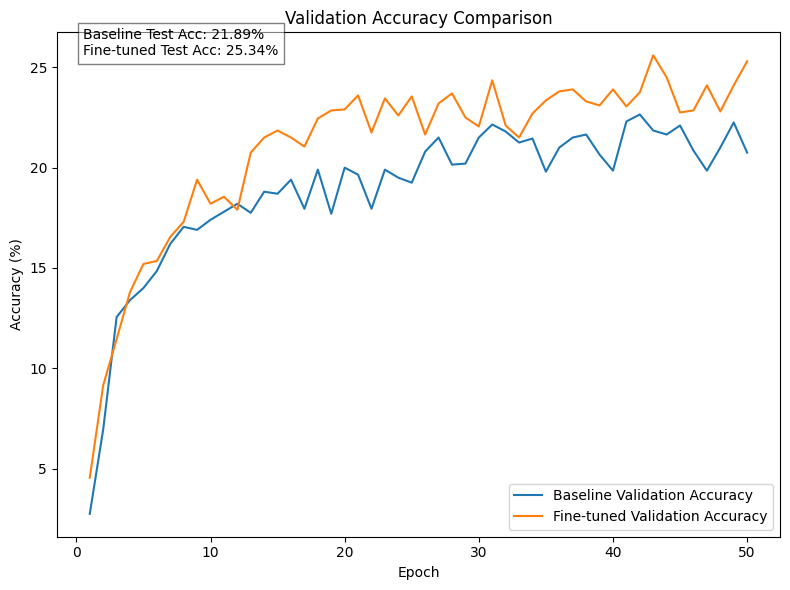

## 4. 실험 분석 및 고찰
- Baseline Model Accuracy : 21.89%
- Our Model Accuracy : 25.34%
- Baseline Model과 Our Model의 실험 결과는 비슷하지만 Our Model의 정확도가 약 3.5% 더 높은 것을 확인하였다.
- SimCLR라는 self-supervised learning방법을 통해 unlabeled된 데이터들의 특징을 파악했기 때문에 10%의 데이터만 사용한 Baseline Model보다 성능이 잘 나온 것 같다.
- 학습 안정성 측면에서는 두 모델이 비슷하게 불안정한 측면을 보였다.
- 하지만 성능 차이가 극적이지 않은 이유는 SimCLR 모델 학습 시 Loss가 4.8749로 학습 자체는 지속적으로 일어났지만, 데이터의 특징을 매우 잘 파악하지는 못했다.
- transform, learning rate 등 다양한 요인 때문에 특징파악을 더 잘 하지 못했다고 생각해 여러 시행착오를 통해 최적의 Hyperparameter를 파악한다면, 더 높은 결과값을 만들 수 있을 것 같다.